In [51]:
import tensorflow as tf
from CONST import SEED, BATCH_SIZE
from neural_networks import FNN, CNN, RNN, CRNN
from utils import set_seed, evaluate, plot_confusion_matrix, make_predictions, calculate_metrics

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [52]:
set_seed(SEED)

In [53]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

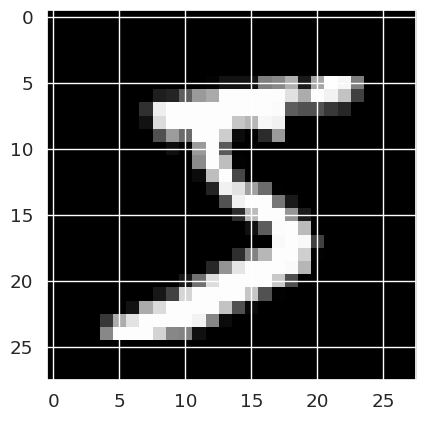

In [54]:
plt.imshow(train_images[0].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()


/home/kieru/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


FNN Evaluation - Accuracy: 0.1021, Precision: 0.0534, Recall: 0.1021
Confusion Matrix:
[[ 88   0  18   7   0 279   7   0 558  23]
 [272   0   0   0   0  94   0   0 769   0]
 [ 62   0   0   0   0 175   5   0 790   0]
 [ 36   0   5   3   0 461   9   1 495   0]
 [ 21   0   7   1   0  28   0   0 924   1]
 [ 34   0   4   4   0 104   1   0 741   4]
 [ 22   0   0   0   0  45   3   0 887   1]
 [ 94   0   3   2   0  56   0   0 869   4]
 [ 51   0   3   4   0  92   1   0 823   0]
 [ 61   0   4   0   0  47   2   0 895   0]]


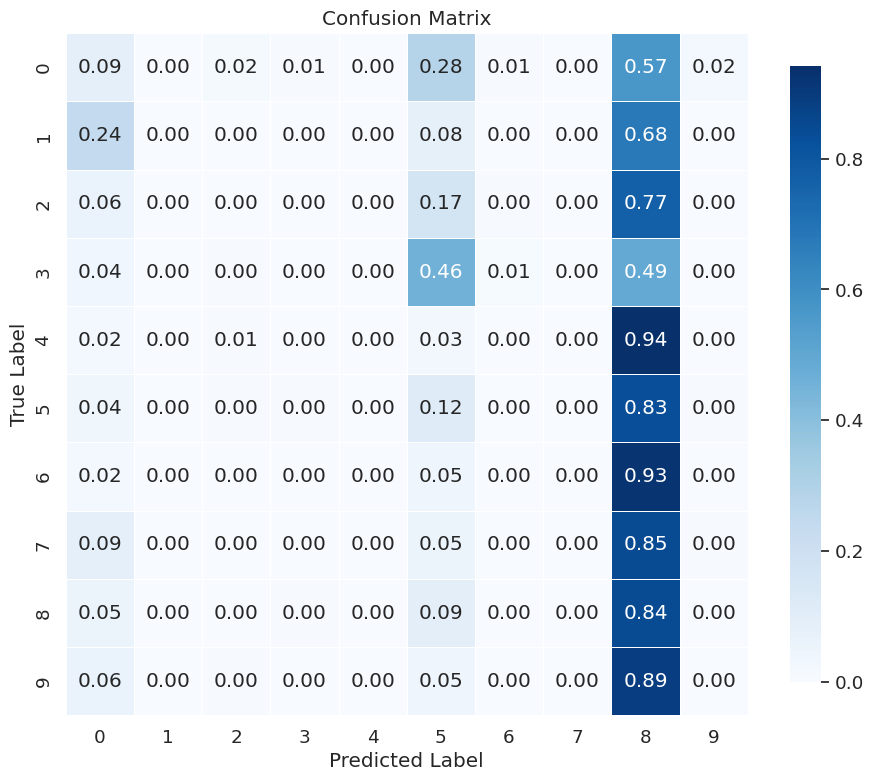

In [55]:
class_names = [str(i) for i in range(10)]  # Assuming you have 10 classes for MNIST

fnn_model = FNN()
fnn_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
fnn_model.fit(train_images, train_labels, epochs=5, batch_size=64, shuffle=True)

predicted_labels = make_predictions(fnn_model, test_images)

accuracy, precision, recall, conf_matrix = calculate_metrics(predicted_labels, np.argmax(test_labels, axis=1))

print(f"FNN Evaluation - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

plot_confusion_matrix(conf_matrix, class_names)